In [1]:
#opening the pickle file that was saved after the cleaning process
import pickle 
file = open("training.pkl",'rb')

In [2]:
# loading the pickjle file
data = pickle.load(file)

In [3]:
data.head()

,Message,Validation1,Engage,CleanedText,PreserveStopwords
13,Hi,8,0,,hi
14,Ok,7,0,,ok
15,No,7,0,,no
18,Ya,7,0,,ya
23,Pm,7,0,,pm


In [4]:
X = data.PreserveStopwords
Y = data.Engage

In [5]:
df = data[['PreserveStopwords', 'Engage']]

In [6]:
df.head()

,PreserveStopwords,Engage
13,hi,0
14,ok,0
15,no,0
18,ya,0
23,pm,0


In [7]:
#installing the fastai packages 
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
  ERROR: Could not find a version that satisfies the requirement torch_nightly (from versions: none)
ERROR: No matching distribution found for torch_nightly


In [8]:
# import the packages
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [9]:
#Splitting the data into train data and test data
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df, test_size = 0.2, random_state = 42)

In [10]:
df_trn.shape, df_val.shape

((37221, 2), (9306, 2))

In [11]:
df_trn.head()

,PreserveStopwords,Engage
4083,can someone pelase answer me chasesupport,0
12446,hi i use the chase app on my phone to deposit ...,1
4219,hsbc uk after opening my student account i sti...,1
4830,hsbc uk your customer service is absolutely di...,1
623,,0


In [12]:
# Columns of text is assigned to TEXT_COLS and Label is assigned to LABEL_COLS
TEXT_COLS = ['PreserveStopwords']
LABEL_COLS = ['Engage']

In [13]:
# Language model data
data_lm = TextLMDataBunch.from_df(os.getcwd(), train_df = df_trn, valid_df = df_val, text_cols=TEXT_COLS)

In [14]:
#batch of text data 
data_lm.show_batch()

idx,text
0,is absolutely xxunk if you can even call it customer service xxbos xxbos hsbc uk i need to change my surname and address in branch will my updated passport and licence along with marriage cert be enough proof xxbos askciti called again and this time they re saying it s a yahoo issue not a macy s issue like i was told last time i m just not receiving the
1,i was charged for insufficient funds in my account amounting to this maybe a over draft fee however the initial charge that caused the overdraft should not be there it s from amazon and i have a free month student prime account https t co c xxunk xxbos sure xxbos seriously need to leave chase they fucking suck anyone have any other suggestions xxbos wellsfargonews you assholes opened a account
2,me so i can give you their phone number xxbos ok where can i see the date where i was approved is it on my account profile in the chase website xxbos iv never seen a credit card company charge you for making payments in ful early until i got with citi xxbos citi you are pathetic bank so are your fucking employees xxbos if apply online the cash back
3,sabb ecare i paid my credit card bill more than an hour ago and the funds were debited from my current account but the outstanding amount is still showing on my credit card bill please let me know why this is xxbos hi it s xxbos hello citi bank thank you for this opportunity so here is my imperfecttoperfect story for travelbigwithciti contest so i am a very shy kind
4,machine in dagupan thanks xxbos chasesupport any plans to update the app to fill the iphone x screen xxbos hsbc uk yeah i don t have any other accounts with you xxbos still have not gotten any more info on my fraud case from you everyone says they are working on it and nothing happens https t co xxunk ay xxbos wellsfargo atm literally just ate my debit card and


In [15]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.7)

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.92E-02


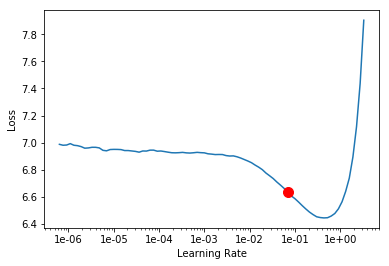

In [17]:
learn.recorder.plot(suggestion=True)

In [23]:
learn.save_encoder('ft_enc')

In [18]:
#best of learning model, learning rate
best_lm_lr = learn.recorder.min_grad_lr
best_lm_lr

0.06918309709189363

In [19]:
# train the learner object with learning rate = 1e-2
learn.fit_one_cycle(1, best_lm_lr)

epoch,train_loss,valid_loss,accuracy,time
0,5.146320,4.692677,0.202812,44:28


#    

In [22]:
# learning model predicting the next 5 words given first two words
learn.predict('I want', n_words=5)

'I want to open a savings account'

#   

# Classification model

In [24]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(os.getcwd(), train_df = df_trn, valid_df=df_val,text_cols=TEXT_COLS, label_cols=LABEL_COLS, bs=32)

In [25]:
# text data and the labeled data
data_clas.show_batch()

text,target
xxbos xxunk xxunk xxunk amen i am jason tole him was nekosolos and awas like honor to send this story in us to glory of his name i was a kid years old xxunk and a was in the phillipines right now live i witness the gresious of god on to me and awas like happy that his tole me this feeling i m am glad and happy becouse of,1
xxbos i ve been waiting to here back from the i believe i was told the cash department as of a couple weeks ago i made a payment on for that was suppose to bring the loan current as i told them my bank shows the money coming out of the account on i haven t heard back from anyone at wellsfargo yet i told them my bank said they,1
xxbos erin davis a few months ago i encountered some financial difficulties i won t go in to a sob story because it isn t important to the issue at hand but i found myself unable to make my credit card payment i got things back on track and called customer service to see about making arrangements to get everything squared away with my account the representative i spoke with,1
xxbos hi i am writing this email to show great dissatisfaction towards citi bank i have marked several email but never got any revert from citi banks end i have never expected such a lame customer service from citi bank the story starts when i made a foreign transaction from citibank card which was against citibanks policy after that bank ask me to submit the undertaking which i did but,1
xxbos i seldom provide feedback but my recent two encounters with citibank triggered my thoughts to provide one i signed up citi premiermiles card with citibank in february this year as i am a frequent traveler and i hope to tap on to citibank s privilege my first request was a temporarily increase of credit limit as i knew i wasn t qualified for a permanent increase i needed to,1


In [26]:
# loading the weights 
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.7)
learn.load_encoder('ft_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07


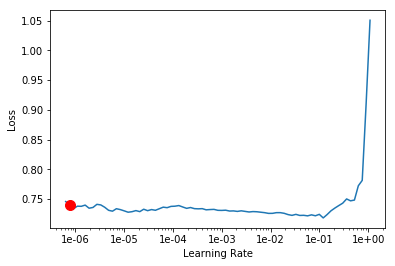

In [27]:
# finding the best learning rate
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [43]:
best_lm_lr = learn.recorder.min_grad_lr
best_lm_lr

0.006309573444801929

In [45]:
# performance of the model with no layers being unfrozen and epochs=5
learn.fit_one_cycle(5, best_lm_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.606595,0.454823,0.784763,00:37
1,0.608407,0.475268,0.793789,00:41
2,0.591351,0.443952,0.796368,00:40
3,0.589492,0.443033,0.795508,00:37
4,0.604431,0.475189,0.785622,00:37


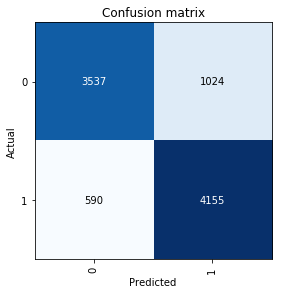

In [52]:
# Confusion matrix for the model prediction
from fastai.version import *

preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn,preds,y,losses)
interp.plot_confusion_matrix()

#    

In [41]:
# Two layers are being unfrozen
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06


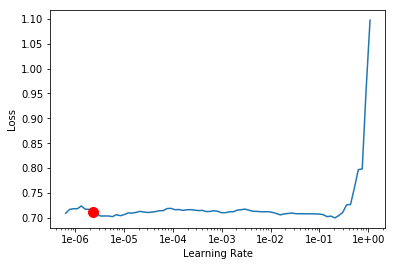

In [42]:
#finding the best learning rate
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [43]:
best_lm_lr = learn.recorder.min_grad_lr
best_lm_lr

2.2908676527677735e-06

epoch,train_loss,valid_loss,accuracy,time
0,0.711770,0.699905,0.505588,42:08
1,0.702048,0.673536,0.572212,39:15
2,0.698006,0.663918,0.598539,41:43
3,0.691286,0.668945,0.566839,39:23
4,0.691059,0.663352,0.595530,44:49


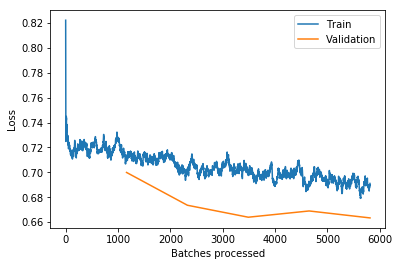

In [45]:
# training the model with 5 epochs
learn.fit_one_cycle(5, best_lm_lr)
learn.recorder.plot_losses()

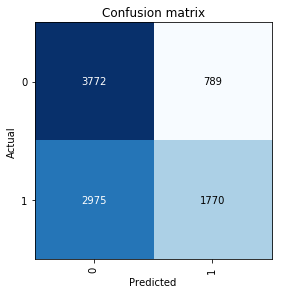

In [46]:
#plotting the confusion matrix
from fastai.version import *

preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn,preds,y,losses)
interp.plot_confusion_matrix()

#    

In [47]:
#All the layers are unfrozen
learn.unfreeze

<bound method Learner.unfreeze of RNNLearner(data=TextClasDataBunch;

Train: LabelList (37221 items)
x: TextList
xxbos can someone pelase answer me chasesupport,xxbos hi i use the chase app on my phone to deposit checks to my checking account if i wanted to use the app to deposit a check that was written to my mom how would i go about doing that,xxbos hsbc uk after opening my student account i still have nt recieved my amazon voucher,xxbos hsbc uk your customer service is absolutely xxunk if you can even call it customer service,xxbos
y: CategoryList
0,1,1,1,0
Path: /Users/rohitbohra/Documents/bank;

Valid: LabelList (9306 items)
x: TextList
xxbos xxunk not good enough too little too late thankfully firstdirect with their excellent customer service which is rare for me tonight are on the case now tv serial xxunk you have lost my custom now,xxbos perfect thank you so much,xxbos i ve been trying to activate my card at http citi com activate at the end it says we re sorry http citi com is

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-03


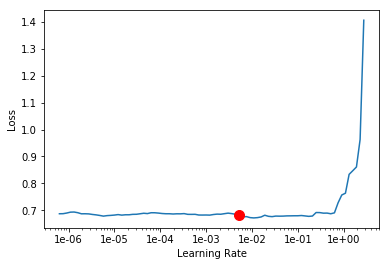

In [48]:
#finding the best learning rate
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [49]:
best_lm_lr = learn.recorder.min_grad_lr
best_lm_lr

0.005248074602497722

epoch,train_loss,valid_loss,accuracy,time
0,0.612191,0.513683,0.775521,44:23
1,0.569155,0.432759,0.798410,46:19
2,0.568110,0.417786,0.815066,43:29
3,0.509216,0.396408,0.826134,42:42
4,0.526981,0.394456,0.826564,43:46


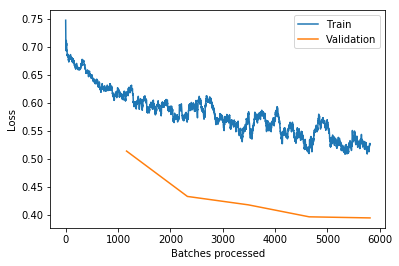

In [50]:
# training the model with 5 epochs and seeing the performance of the model
learn.fit_one_cycle(5, best_lm_lr)
learn.recorder.plot_losses()

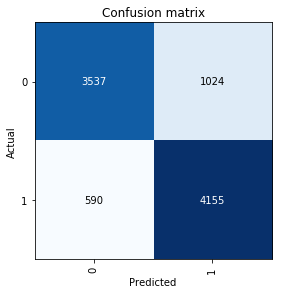

In [51]:
#plotting of Confusion Matrix
from fastai.version import *

preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn,preds,y,losses)
interp.plot_confusion_matrix()

epoch,train_loss,valid_loss,accuracy,time
0,0.526342,0.441469,0.810660,44:56
1,0.505760,0.411749,0.821083,46:14
2,0.529949,0.390205,0.827960,42:57
3,0.535112,0.399645,0.828390,40:25
4,0.540120,0.400459,0.824522,42:39
5,0.522433,0.391001,0.830539,46:05
6,0.501271,0.409175,0.829572,41:38
7,0.501646,0.391458,0.837847,41:07
8,0.485213,0.394269,0.836342,42:57
9,0.485791,0.396591,0.835482,43:30


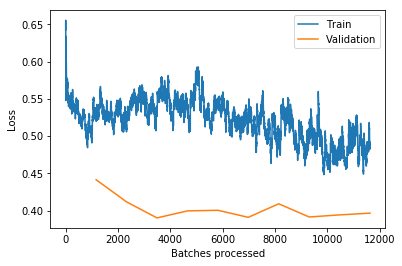

In [53]:
# training the model with 10 epochs and seeing the performance of the model
learn.fit_one_cycle(10, best_lm_lr)
learn.recorder.plot_losses()

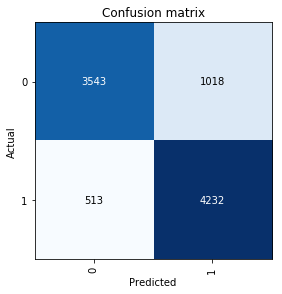

In [54]:
# plotting of the Confusion Matrix
from fastai.version import *

preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn,preds,y,losses)
interp.plot_confusion_matrix()

In [55]:
# Result of the prediction
learn.show_results()

text,target,prediction
xxbos hello my l bank i have two accounts with your sick bank one is nre and the other one is xxunk account initially it was s b account then in my s b account was converted to xxunk then in addition to that nre account was added to my profile due to my overseas movement for work i am here to share an ugly pathetic frustrating all other bad,1,1
xxbos in response to a comment i made on facebook people have tried gaining the information for the loan we attempted with wells fargo i really do nt see a point to this because we have been reached out to by multiple people within the wells fargo company to resolve the issues we faced and just days ago we were told again there was nothing they you can do to,1,1
xxbos re citi premier card ending in sign up bonus i d xxunk to file a complaint i was not credited with the points i was promised for signing up and spending within the first months of opening the account i complied with all the requirements and even confirmed twice over the phone with a citi representative that i was eligible before and when the card was issued i depend,1,1
xxbos i used to love chase bank especially my home branch i even opened a business account when i started my business i actually enjoyed going into the bank i ve had a bank account with citibank for over thirty years it s still there i was going to move that account to chase but i didn t and now i m so glad i didn t what i liked,1,1
xxbos hi i just want to provide some feedback about my horrible experiences with chase branches i have a chase premier checking account united chase credit card and a mortgage through chase so i decided to open a safety deposit box with chase as well at first i called the chase branch at xxunk st i must have called at least times to check if they had any availability but,1,1


#   

In [56]:
# showing the importance of words in the review sample
import matplotlib.cm as cm
txt_ci = TextClassificationInterpretation.from_learner(learn)

In [58]:
test_text = "hello my l bank i have two accounts with your sick bank one is nre and the other one is xxunk account initially it was s b account then in my s b account was converted to xxunk then in addition to that nre account was added to my profile due to my overseas movement for work i am here to share an ugly pathetic frustrating all other bad"
txt_ci.show_intrinsic_attention(test_text, cmap=cm.Purples)

In [59]:
txt_ci.intrinsic_attention(test_text)[1]

tensor([0.4832, 0.5509, 0.8416, 1.0000, 0.3921, 0.6312], device='cuda:0')

# STEPS TAKEN 

1) ULMFIT uses a pre-trained text data of Wikitext-103. Using the pretrained language model we add a new classification layer on top of it, this make the model a pre-trained classification model.

2) We train a language model with the text data by using the pre-trained weights of the language model.

3) On top of language model we add a classification layer, which predict if the review is Engageble or Non-Engagebale.

4) We experiment with the number of layers to unfreeze and then see which classification model performs well by considering the accuracy.


In [64]:
from prettytable import PrettyTable    
x = PrettyTable()
 
x.field_names = ["No. of Layers Unfreezed", "Epochs", "Train Loss", "Validation Loss", "Accuracy"]
x.add_row(["None", 5, 0.604431, 0.475189, 78.56])
x.add_row([-2, 5, 0.691059, 0.663352, 59.55])
x.add_row(["Unfreeze all layers", 5, 0.526981, 0.394456, 82.65])
x.add_row(["Unfreeze all layers", 10, 0.485791, 0.396591,83.54])


print('\n\t\t\t\t Performance Table')
print(x)


				 Performance Table
+-------------------------+--------+------------+-----------------+----------+
| No. of Layers Unfreezed | Epochs | Train Loss | Validation Loss | Accuracy |
+-------------------------+--------+------------+-----------------+----------+
|           None          |   5    |  0.604431  |     0.475189    |  78.56   |
|            -2           |   5    |  0.691059  |     0.663352    |  59.55   |
|   Unfreeze all layers   |   5    |  0.526981  |     0.394456    |  82.65   |
|   Unfreeze all layers   |   10   |  0.485791  |     0.396591    |  83.54   |
+-------------------------+--------+------------+-----------------+----------+


# CONCLUSION

The model performs fairly well with ULMFIT and accuracy is high when compared to the previously built models.
We use pre-trained weights which help in building a good classification model. 

The best accuracy is of 83.54% when we unfreeze all layers.

When compared to previous models this model performed better than the previous ones.